In [3]:
class PID:
    def __init__(self, Kp, Ki, Kd, target, windup, max_slew):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0
        self.target = target
        self.windup = windup
        self.last_output = 0
        self.max_slew = max_slew
        
    def clamp(self, n, smallest, largest): 
        return max(smallest, min(n, largest))
    
    def slew(self, output, dt):
        max_delta = self.max_slew * dt
        delta = output - self.last_output
        delta = self.clamp(delta, -max_delta, max_delta)
        self.last_output += delta
        return self.last_output
    
    def update(self, input, dt):
        error = self.target - input
        self.integral += error * dt
        self.integral = self.clamp(self.integral, -self.windup, self.windup)
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        
        proportional = self.Kp * error
        integral_term = self.Ki * self.integral
        derivative_term = self.Kd * derivative

        output = proportional + integral_term + derivative_term
        return self.slew(output, dt) if self.max_slew is not None else output


In [29]:
class Motor:
    def __init__(self, kV=100.0, inertia=1.0, damping=0.1):
        """
        kV: Motor velocity constant (rad/s per volt)
        inertia: Motor inertia (higher = slower acceleration)
        damping: Friction or air resistance
        """
        self.kV = kV
        self.inertia = inertia
        self.damping = damping
        self.velocity = 0.0
        self.voltage = 0.0
        
    def apply_voltage(self, voltage):
        """Apply a voltage to the motor."""
        self.voltage = voltage
        
    def update(self, dt):
        """Simulate the motor physics over a timestep dt."""
        # Target velocity from voltage (ideal no-load speed)
        target_velocity = self.kV * self.voltage
        
        # Calculate forces: inertia tries to resist change, damping slows it down
        acceleration = ((target_velocity - self.velocity)- (self.damping * self.velocity)) / self.inertia
        
        # Update velocity based on acceleration
        self.velocity += acceleration * dt
        
        return self.velocity


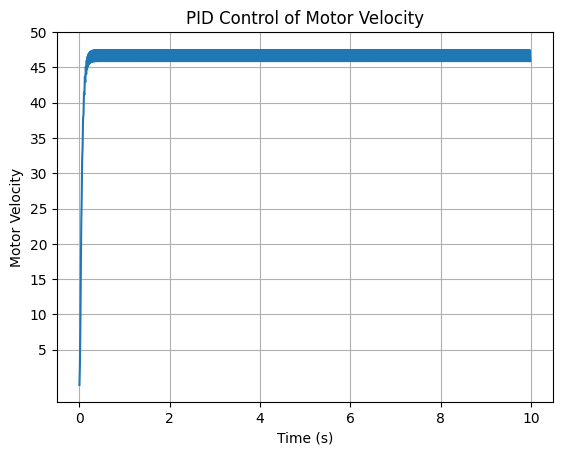

-4.115456238361276


In [55]:
import matplotlib.pyplot as plt

pid = PID(Kp=15, Ki=1, Kd=0.5, target=50.0, windup=50, max_slew=700)
motor = Motor(kV=2.0, inertia=0.05, damping=0.05)

dt = 0.01
time_span = 10.0
steps = int(time_span / dt)

velocities = []
times = []

for step in range(steps):
    current_velocity = motor.velocity
    control_voltage = pid.update(current_velocity, dt)
    motor.apply_voltage(control_voltage)
    motor.update(dt)
    
    velocities.append(current_velocity)
    times.append(step * dt)

# Plot result
plt.plot(times, velocities)
plt.xlabel('Time (s)')
plt.ylabel('Motor Velocity')
plt.yticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.title('PID Control of Motor Velocity')
plt.grid(True)
plt.show()

# final error

print(velocities[-1] - 50.0)


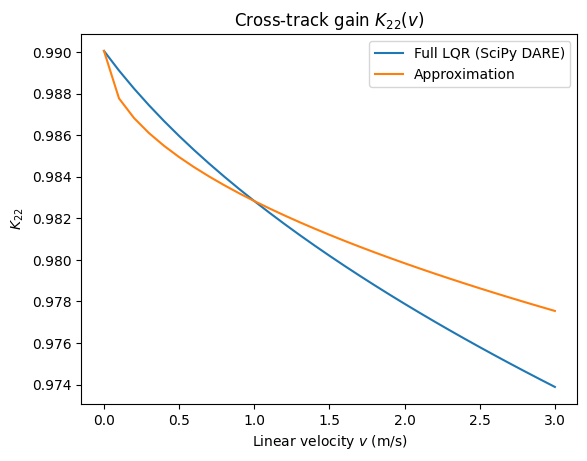

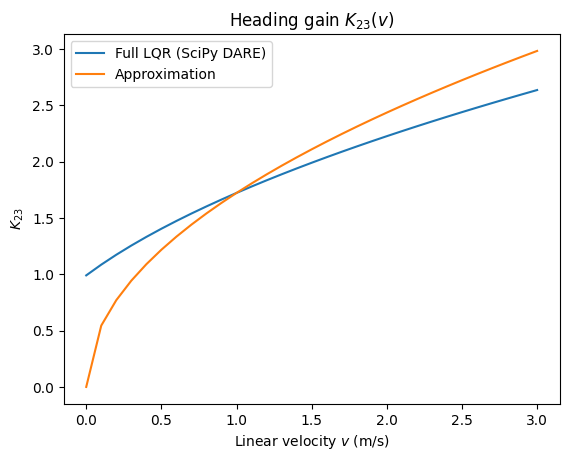

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are

# Sample parameters
dt = 0.02
maxV = 3.0
v_list = np.linspace(0, maxV, 31)

# Example cost matrices
Q = np.diag([1.0, 1.0, 1.0])
R = np.diag([1.0, 1.0])

# Compute full LQR gains using scipy's DARE solver (with small-v safeguard)
K22_full = []
K23_full = []
for v in v_list:
    # Avoid singular A for v near zero by enforcing a minimum epsilon
    safe_v = v if abs(v) >= 1e-4 else 1e-4
    
    # Continuous-time linearized system in robot frame
    A = np.array([[0, 0, 0],
                  [0, 0, safe_v],
                  [0, 0, 0]])
    B = np.array([[1, 0],
                  [0, 0],
                  [0, 1]])
    
    # Discretize A, B
    A_d = np.eye(3) + A * dt
    B_d = B * dt
    
    # Solve discrete-time Riccati equation
    S = solve_discrete_are(A_d, B_d, Q, R)
    
    # Compute LQR gain: K = (Bᵀ S B + R)⁻¹ Bᵀ S A
    K = np.linalg.inv(B_d.T @ S @ B_d + R) @ (B_d.T @ S @ A_d)
    
    K22_full.append(K[1, 1])
    K23_full.append(K[1, 2])

K22_full = np.array(K22_full)
K23_full = np.array(K23_full)

# Extract approximate-law constants from v=0 and v=1
ky0    = K22_full[0]
idx1   = np.argmin(np.abs(v_list - 1.0))
ky1    = K22_full[idx1]
ktheta = K23_full[idx1]

# Analytic approximations
K22_approx = ky0 + (ky1 - ky0) * np.sqrt(v_list)
K23_approx = ktheta * np.sqrt(v_list)

# Plot Cross-track gain K22(v)
plt.figure()
plt.plot(v_list, K22_full, label='Full LQR (SciPy DARE)')
plt.plot(v_list, K22_approx, label='Approximation')
plt.title('Cross-track gain $K_{22}(v)$')
plt.xlabel('Linear velocity $v$ (m/s)')
plt.ylabel('$K_{22}$')
plt.legend()

# Plot Heading gain K23(v)
plt.figure()
plt.plot(v_list, K23_full, label='Full LQR (SciPy DARE)')
plt.plot(v_list, K23_approx, label='Approximation')
plt.title('Heading gain $K_{23}(v)$')
plt.xlabel('Linear velocity $v$ (m/s)')
plt.ylabel('$K_{23}$')
plt.legend()

plt.show()


In [80]:
import numpy as np
from scipy.linalg import solve_discrete_are
from scipy.linalg import expm


class LTVController:
    def __init__(self, dt, maxV, Q, R, num=81):
        self.dt = dt
        self.maxV = maxV
        self.v_list = np.linspace(0.0, maxV, num)
        self.Q = np.diag(Q)
        self.R = np.diag(R)
        self.K_list = np.zeros((num, 2, 3))
        
        for i, v in enumerate(self.v_list):
            safe_v = v if abs(v) >= 1e-6 else 1e-6
            A = np.array([[0, 0, 0],
                          [0, 0, safe_v],
                          [0, 0, 0]])
            B = np.array([[1, 0],
                          [0, 0],
                          [0, 1]])
            # discretize A, B
            
            n, m = A.shape[0], B.shape[1]
            M = np.zeros((n + m, n + m))
            M[:n,   :n]   = A
            M[:n,   n:]   = B
            
            # bottom rows are already zero

            # exponentiate
            Mexp = expm(M * dt)

            # extract discrete A and B
            A_d = Mexp[:n, :n]
            B_d = Mexp[:n, n:]

            # A_d = np.eye(3) + A * dt
            # B_d = B * dt

            S = solve_discrete_are(A_d, B_d, self.Q, self.R)
            # compute LQR gain K = (Bᵀ S B + R)⁻¹ Bᵀ S A
            K = np.linalg.inv(B_d.T @ S @ B_d + self.R) @ (B_d.T @ S @ A_d)
            self.K_list[i] = K  # 2×3 matrix
        
    def get_gain(self, v_ref: float) -> np.ndarray:

        # clamp into [0, maxV]
        v = float(np.clip(v_ref, 0.0, self.maxV))
        # find right-hand index
        idx = np.searchsorted(self.v_list, v)
        if idx == 0:
            return self.K_list[0]
        if idx >= len(self.v_list):
            return self.K_list[-1]
        # linear interpolation
        return self.K_list[idx-1]
    
    def calculate(self, error: np.ndarray, v_ref: float, omega_ref: float) -> np.ndarray:
        
        K = self.get_gain(v_ref)          # shape (2,3)
        delta_u = K @ error               # shape (2,)
        return np.array([v_ref + delta_u[0],
                         omega_ref + delta_u[1]])

# Example usage:
if __name__ == "__main__":
    dt = 0.02
    maxV = 82
    Q = [1.0, 1.0, 1.0]
    R = [1.0, 1.0]
    controller = LTVController(dt, maxV, Q, R)
    err = np.array([0.8, -0.5, -0.02])
    v_ff = 42.0       # feedforward linear speed
    omega_ff = 0.5   # feedforward angular speed
    cmd = controller.calculate(err, v_ff, omega_ff)
    print(f"Commanded [v, ω] = {cmd}")


Commanded [v, ω] = [42.79204   -0.1304819]
